In [1]:
!conda install shapely descartes pytables geopandas lightgbm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - descartes
    - geopandas
    - lightgbm
    - pytables
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    hdf4-4.2.13                |       h3ca952b_2         916 KB
    munch-2.3.2                |           py36_0          13 KB
    poppler-data-0.4.9         |                0         3.5 MB
    geopandas-0.4.1            |             py_0         891 KB
    proj4-5.0.1                |       h14c3975_0         7.0 MB
    libspatialite-4.3.0a       |      he475c7f_19         3.1 MB
    freexl-1.0.5               |       h14c3975_0          44 KB
    

In [ ]:
!conda install -c conda-forge tqdm -y

Solving environment: / 

# Exploratory Data Analysis

In [27]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()

plt.style.use('seaborn')

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [29]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [30]:
data = pd.concat([train, test], axis=0)
data.shape

(1017199, 11)

# Timing
Time-related features

In [31]:
data['minute_entry'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [32]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

# Distance Evaluation
Euclidian, Minkowski, Haversine distances.

In [33]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [34]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [35]:
data = data[data.euclidian_distance!=0]
data.shape

(491966, 19)

### Quadrants

In [36]:
x_center = center['x_min'] + ((center['x_max']-center['x_min'])/2)
y_center = center['y_min'] + ((center['y_max']+center['y_min'])/2)

In [37]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

### Distances to Center Middle Point

In [38]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [39]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [40]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [41]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

### Distances from Center Borders
Euclidian distance from point to city center borders.

In [42]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])

center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [43]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

for side in ['left', 'right', 'lower', 'upper']:
    data[f'distance_{side}_border'] = [distance_to_border(x, y, direction=side) for x, y in zip(data.x_entry, data.y_entry)]

# Angles w.r.t Center
Mid and vertex-related angles on a per point basis

In [44]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,0.173281,0.132425,0.711798,0.044184,0.184758


In [45]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,9.928271,7.587407,40.782997,2.531528,10.585844


# Target feature

In [46]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

# Grid Sections
We'll start off dividing our trajectory map in grids meant to cover any posible entry point in our data

In [47]:
xmin, ymin, xmax, ymax = data.x_entry.min(), data.y_entry.min(), data.x_entry.max(), data.y_entry.max()

xmax-xmin, ymax-ymin

(36068.62821192667, 340258.3224131949)

In [22]:
from shapely.geometry import Polygon

# 10x3 grids, given the height/width ratio is predominantly vertical
y_count = 4
x_count = 10

grid_h = (ymax-ymin)/y_count
grid_w = (xmax-xmin)/x_count

grids = {'{}_{}'.format(i+1,j+1): Polygon([
            (xmin + grid_w*i, ymin + grid_h*j), (xmin + grid_w*i, ymin + grid_h*(j+1)),
            (xmin + grid_w*(i+1), ymin + grid_h*(j+1)), (xmin + grid_w*(i+1), ymin + grid_h*j)]) \
         for i in range(0, x_count) \
         for j in range(0, y_count)}

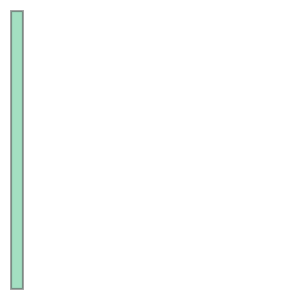

In [23]:
grids['1_1']

In [140]:
grid_cols = ['entry_grid_' + grid for grid in grids.keys()]
data = data.reindex(columns=data.columns.tolist() + grid_cols)

In [141]:
for (_, grid), col in zip(grids.items(), grid_cols):
    data[col] = data.apply(lambda row: grid.contains(Point(row['x_entry'], row['y_entry'])), axis=1)

In [142]:
data[grid_cols] = data[grid_cols].astype(int)

In [143]:
for col in grid_cols:
    data.loc[data[col] == 1, 'neighbors'] = data[col].sum()

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,entry_grid_8_4,entry_grid_9_1,entry_grid_9_2,entry_grid_9_3,entry_grid_9_4,entry_grid_10_1,entry_grid_10_2,entry_grid_10_3,entry_grid_10_4,neighbors
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,0,0,0,4034.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,0,0,0,11235.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,0,0,0,24758.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,0,0,0,24758.0
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0,0,0,0,0,0,0,0,0,24758.0


In [48]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)

In [49]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [50]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

blind_cols = ['distance_blind', 'x_delta_blind', 'y_delta_blind', 'time_delta_blind']
data.loc[data.time_delta_blind < 0, blind_cols] = 0

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle,is_inside_city_entry,is_inside_city_exit,center_permanency,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,0,0,0.0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,10.788397,2.420383,17.796301,0,0,0.0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,27.292186,3.297664,13.409474,0,0,0.0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,40.782997,2.531528,10.585844,0,0,0.0,14.416667,64.565305,551.388913,555.156205


In [55]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

# Time: Continuous features

In [56]:
data['hrs_cont_entry'] = [t / pd.Timedelta(hours=1) for t in data.time_entry]
data['min_cont_entry'] = [t / pd.Timedelta(minutes=1) for t in data.time_entry]
data['sec_cont_entry'] = [t / pd.Timedelta(seconds=1) for t in data.time_entry]

data['hrs_cont_exit'] = [t / pd.Timedelta(hours=1) for t in data.time_exit]
data['min_cont_exit'] = [t / pd.Timedelta(minutes=1) for t in data.time_exit]
data['sec_cont_exit'] = [t / pd.Timedelta(seconds=1) for t in data.time_exit]

### Aggregating features

In [57]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hrs_cont_entry', 'min_cont_entry',
               'sec_cont_entry', 'hour_entry', 'first_quadrant_entry', 'third_quadrant_entry',
               'fourth_quadrant_entry', 'second_quadrant_entry', 'trajectory_number', 'distance_cc_entry',
               'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry', 'distance_left_border',
               'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_mean,cc_xmin_ymax_angle_max,cc_xmin_ymax_angle_std,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,NaN,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.859023,3.297664,0.620331,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774


# Sequence Data

In [95]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [96]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774,1.0,4.0,5


In [97]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774,1.0,4.0,5


In [98]:
grouped = grouped.drop('sequence', axis=1)

In [99]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(144216, 985)

In [100]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,cc_xmax_ymax_angle_sum_1,cc_xmax_ymax_angle_sum_2,cc_xmax_ymax_angle_sum_3,cc_xmax_ymax_angle_sum_4,cc_xmax_ymax_angle_sum_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.796301,31.205774,41.791618,5.0,5.0,5.0,5.0,5.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,NaN,NaN,NaN,1.149404,NaN,NaN,NaN,NaN,1.149404,...,NaN,NaN,NaN,NaN,58.628646,NaN,NaN,NaN,NaN,1.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,58.628646,40.832345,NaN,NaN,NaN,2.0,2.0


In [101]:
data_sequence = data_sequence.reset_index()

In [102]:
data_sequence.shape

(144216, 986)

# Trajectories' Origin Point Features

It is a logical estimate that an extensive group in all recorded trajectories will eventually return to their origin point in the day - relating, in this case, to a person's return home. Dealing with paths distributed in space and time, the current-point to origin-point correlation levels hold a considerable chance to be proportional to either spatial coordinates, time, or both.

With that in mind, let us then compute features focused on current-to-origin point differences.

In [105]:
is_aggr_col = lambda col: any(col.endswith(aggr) for aggr in ['_max', '_min', '_std', '_mean', '_sum'])
origin_cols = [x for x in data.select_dtypes([np.number]).columns if not is_aggr_col(x)]

origin_data = data.groupby('hash').nth(0)[origin_cols]
origin_data.columns = [f'origin_{c}' for c in origin_cols]

origin_data = origin_data.reset_index()

In [106]:
if data_sequence.columns.contains('origin_time'):
    data_sequence = data_sequence[data_sequence.columns.drop(origin_data.columns)]

data_sequence = data_sequence.merge(origin_data, on='hash')

In [75]:
def compute_deltas_for(df, origin_pt_prefix, origin_pt_sufix, current_pt_sufix):
    """
    Computes deltas in a DataFrame for time, distance, angle and the likes.
    
    For a number of metrics ranging from velocity to permanency in the city center,
    trajectory hour count and xy coordinates, this computes the difference between
    values in current and origin points. Indexes for both - origin, current - points
    are assumed to follow a {prefix}_{index}_{sufix} pattern, where {prefix} and {sufix} may
    coexist, but cannot both be empty.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing both current and origin point indexes, and also the one to receive delta results.
    origin_pt_prefix : str
        The prefix on indexes related to deltas' origin point
    origin_pt_sufix : str
        The sufix on indexes related to deltas' origin point
    current_pt_sufix : str
        The sufix on indexes related to deltas' current point
    
    Returns
    -------
    pandas.DataFrame
        The input DataFrame, with calculated delta features within.
    """
    pfx_origin = origin_pt_prefix if origin_pt_prefix is not None else ''
    sfx_origin = origin_pt_sufix if origin_pt_sufix is not None else ''
    sfx_current = current_pt_sufix if current_pt_sufix is not None else ''
    
    pfx_delta = pfx_origin if pfx_origin != '' else sfx_origin
    sfx_delta = f'to_{sfx_current}' if sfx_current != '' else ''
    
    pfx = lambda prefix: f'{prefix}_' if prefix != '' else ''
    sfx = lambda sufix: f'_{sufix}' if sufix != '' else ''
    
    # Index formatting lambdas
    current = lambda index: f'{index}_{sfx_current}'
    origin = lambda index: f'{pfx(pfx_origin)}{index}{sfx(sfx_origin)}'
    delta = lambda index: f'delta_{pfx_delta}_{sfx_delta}_{index}'
    
    
    # Generic deltas
    leaking = ['center_permanency']
    non_leaking = ['vmin', 'vmax', 'vmean', 'x_diff_entry', 'y_diff_entry', 'direction_entry']
    iterable_feats = non_leaking + leaking if sfx_current != window_reference else non_leaking
    
    for idx in iterable_feats:
        df[delta(idx)] = df[current(idx)] - df[origin(idx)]

    # Time-related deltas
    df[delta('hr_entry')] = df[current('hrs_cont_entry')] - df[origin('hrs_cont_entry')]
    df[delta('min_entry')] = df[current('min_cont_entry')] - df[origin('min_cont_entry')]
    df[delta('sec_entry')] = df[current('sec_cont_entry')] - df[origin('sec_cont_entry')]
    
    df[delta('still_time_min')] = df[current('min_cont_entry')] - df[origin('min_cont_exit')]
    df[delta('still_time_sec')] = df[current('sec_cont_entry')] - df[origin('sec_cont_exit')]

    # Distance-related deltas
    df[delta('d_entry')] = euclidian_distance(df[origin('x_entry')], df[origin('y_entry')],
                                                   df[current('x_entry')], df[current('y_entry')])
    
    df[delta('d_exit')] = euclidian_distance(df[origin('x_exit')], df[origin('y_exit')],
                                                  df[current('x_entry')], df[current('y_entry')])

    for side in ['left', 'right', 'lower', 'upper']:
        df[delta(f'{side}_border')] = df[current(f'distance_{side}_border')] - df[origin(f'distance_{side}_border')]

    df[delta('d_cc')] = df[current('distance_cc_entry')] - df[origin('distance_cc_entry')]

    # Angle-related deltas
    for vertex in ['xmin_ymin', 'xmax_ymin', 'xmin_ymax', 'xmax_ymax', 'middle']:
        df[delta(f'^_{vertex}')] = df[current(f'cc_{vertex}_angle')] - df[origin(f'cc_{vertex}_angle')]
    
    return df

In [103]:
for i in range(1, window_reference):
    for j in range(window_reference, window_reference+1):
        if i < j:
            data_sequence = compute_deltas_for(data_sequence,
                                               origin_pt_prefix=None,
                                               origin_pt_sufix=i,
                                               current_pt_sufix=j)

In [107]:
data_sequence = compute_deltas_for(data_sequence,
                                   origin_pt_prefix='origin',
                                   origin_pt_sufix=None,
                                   current_pt_sufix=window_reference)

In [108]:
data_sequence = data_sequence[data_sequence.columns.drop(
    [x for x in data_sequence.columns.ravel() if x.find('origin_time_') != -1]
)]

# Training and Evaluation

In [109]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 1150)

In [110]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 1150)

In [111]:
# TODO: Remove this or the "+ grid_cols" below
grid_cols = []

In [112]:
drop_cols = list(x for x in data.columns if 'exit' in x) + grid_cols
drop_cols += ['euclidian_distance', 'minkowski_distance', 'harvesine_distance',
              'center_permanency', 'has_crossed_city', 'velocity']
drop_cols += [f'origin_{col}' for col in drop_cols]
drop_cols += [f'delta_{col}' for col in drop_cols if col.startswith('origin_')]

drop_cols = [f'{col}_{window_reference}' for col in drop_cols]
drop_cols += [f'{col}_i' for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [113]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

((53518, 1150), (13380, 1150))

In [114]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7672305764411027

In [465]:
# Score 0.744901160966426 | 0.89469
# Score 0.7465277777777779 | 0.89441
# Score 0.7432216905901117 | 0.89358
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

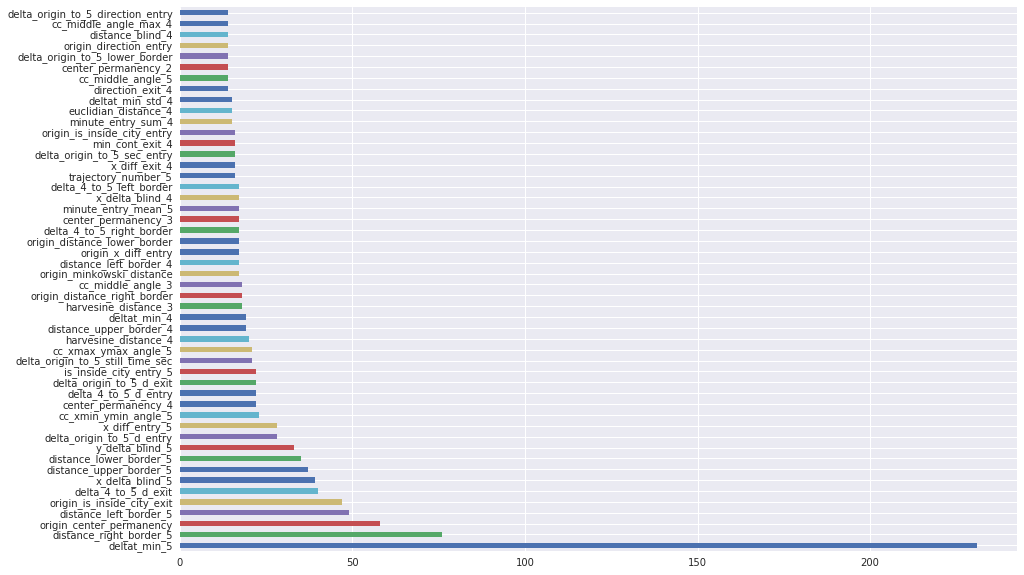

In [115]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [116]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [117]:
data_test.shape

(33515, 1150)

In [118]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [119]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [140]:
data_sequence.center_permanency_4.isna().sum() / data_sequence.center_permanency_4.notna().sum()

0.2729134303064539

In [141]:
data_test.center_permanency_4.isna().sum() / data_test.center_permanency_4.notna().sum()

0.2875033613768199

In [142]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [143]:
pd.Series(yhat).value_counts()

0.0    26903
1.0     6612
dtype: int64

In [144]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,...,delta_origin_to_5_right_border,delta_origin_to_5_lower_border,delta_origin_to_5_upper_border,delta_origin_to_5_d_cc,delta_origin_to_5_^_xmin_ymin,delta_origin_to_5_^_xmax_ymin,delta_origin_to_5_^_xmin_ymax,delta_origin_to_5_^_xmax_ymax,delta_origin_to_5_^_middle,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-46608.594834,-46617.135649,-46608.594834,-46618.640311,NaN,NaN,NaN,NaN,NaN,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,17.29,NaN,NaN,NaN,NaN,17.29,NaN,...,8633.290283,8627.407404,8628.275187,-8629.912052,NaN,NaN,NaN,NaN,NaN,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-95513.123373,-138175.456771,-78793.867646,-138175.150894,NaN,NaN,NaN,NaN,NaN,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [145]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [146]:
submission.to_csv('../data/submission46_julio.csv', index=False)

# Preprocessed Data Saving

In [84]:
data_sequence.to_hdf('../data/preprocessed/data_sequence_0.89469.hdf', key='deltas', mode='w')